# DoWhy: Interpreters for Causal Estimators

This is a quick introduction to the use of interpreters in the DoWhy causal inference library.
We will load in a sample dataset, use different methods for estimating the causal effect of a (pre-specified)treatment variable on a (pre-specified) outcome variable and demonstrate how to interpret the obtained results.

First, let us add the required path for Python to find the DoWhy code and load all required packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

Now, let us load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome.

Beta is the true causal effect.

In [3]:
data = dowhy.datasets.linear_dataset(beta=1,
        num_common_causes=5, 
        num_instruments = 2,
        num_treatments=1,
        num_discrete_common_causes=1,
        num_samples=10000,
        treatment_is_binary=True,
        outcome_is_binary=False)
df = data["df"]
print(df[df.v0==True].shape[0])
df

8289


,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,0.0,0.513208,-0.881512,-0.270259,-0.318695,-0.617171,1,True,0.767568
1,0.0,0.591269,1.516367,0.859590,-0.039274,0.878893,2,True,3.759680
2,0.0,0.452094,-0.620301,0.737271,-2.708658,0.908638,1,True,1.325515
3,0.0,0.488315,-0.367811,2.320921,-0.764148,1.351333,1,True,2.989382
4,0.0,0.321277,1.255035,0.126912,1.063170,1.150792,1,True,3.393773
...,...,...,...,...,...,...,...,...,...
9995,0.0,0.878614,-0.720907,1.373865,2.004316,0.101772,1,True,2.737486
9996,0.0,0.827242,-1.440029,0.734998,-0.593142,0.296258,3,True,2.851160
9997,0.0,0.003162,-0.405228,-0.175787,-0.786617,1.410155,0,True,1.574593
9998,0.0,0.584982,1.777127,1.350656,-1.844339,-0.870784,1,False,0.312588


Note that we are using a pandas dataframe to load the data.

## Identifying the causal estimand

We now input a causal graph in the GML graph format.

In [4]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"],
        instruments=data["instrument_names"]
        )

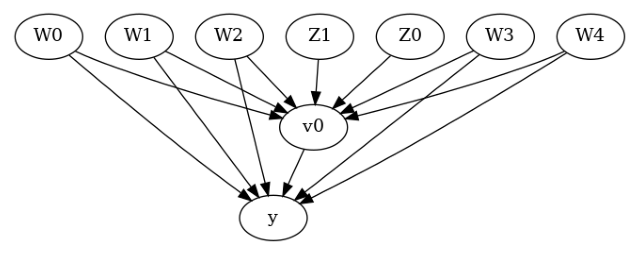

In [5]:
model.view_model()

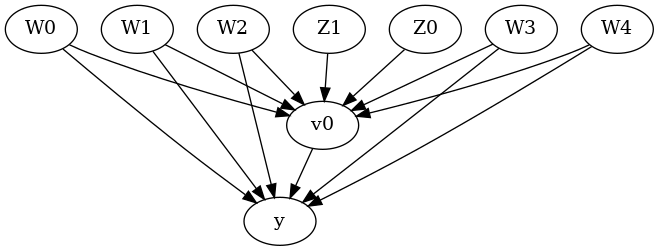

In [6]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get a causal graph. Now identification and estimation is done.

In [7]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W2,W3,W1,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W3,W1,W4,U) = P(y|v0,W0,W2,W3,W1,W4)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Method 1: Propensity Score Stratification

We will be using propensity scores to stratify units in the data.

In [8]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W2,W3,W1,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W3,W1,W4,U) = P(y|v0,W0,W2,W3,W1,W4)

## Realized estimand
b: y~v0+W0+W2+W3+W1+W4
Target units: att

## Estimate
Mean value: 1.003070136296005

Causal Estimate is 1.003070136296005


### Textual Interpreter

The textual Interpreter describes (in words) the effect of unit change in the treatment variable on the outcome variable.

In [9]:
# Textual Interpreter
interpretation = causal_estimate_strat.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [v0] from 0 to 1 causes an increase of 1.003070136296005 in the expected value of the outcome [['y']], over the data distribution/population represented by the dataset.


### Visual Interpreter

The visual interpreter plots the change in the standardized mean difference (SMD) before and after Propensity Score based adjustment of the dataset. The formula for SMD is given below.


$SMD = \frac{\bar X_{1} - \bar X_{2}}{\sqrt{(S_{1}^{2} + S_{2}^{2})/2}}$

Here, $\bar X_{1}$ and $\bar X_{2}$ are the sample mean for the treated and control groups.


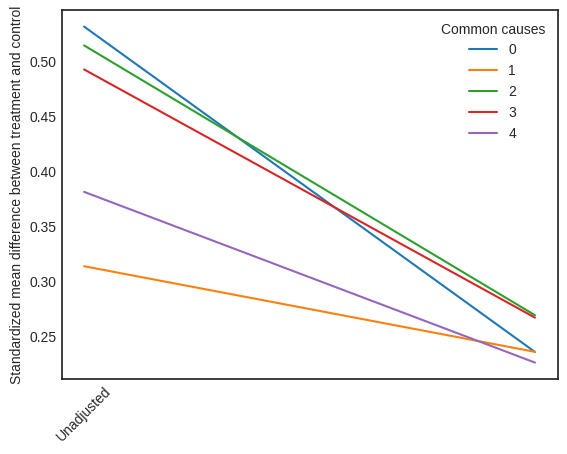

In [10]:
# Visual Interpreter
interpretation = causal_estimate_strat.interpret(method_name="propensity_balance_interpreter")

This plot shows how the SMD decreases from the unadjusted to the stratified units. 

## Method 2: Propensity Score Matching

We will be using propensity scores to match units in the data.

In [11]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="atc")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W2,W3,W1,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W3,W1,W4,U) = P(y|v0,W0,W2,W3,W1,W4)

## Realized estimand
b: y~v0+W0+W2+W3+W1+W4
Target units: atc

## Estimate
Mean value: 1.0211431492216658

Causal Estimate is 1.0211431492216658


In [12]:
# Textual Interpreter
interpretation = causal_estimate_match.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [v0] from 0 to 1 causes an increase of 1.0211431492216658 in the expected value of the outcome [['y']], over the data distribution/population represented by the dataset.


Cannot use propensity balance interpretor here since the interpreter method only supports propensity score stratification estimator.

## Method 3: Weighting

We will be using (inverse) propensity scores to assign weights to units in the data. DoWhy supports a few different weighting schemes:
1. Vanilla Inverse Propensity Score weighting (IPS) (weighting_scheme="ips_weight")
2. Self-normalized IPS weighting (also known as the Hajek estimator) (weighting_scheme="ips_normalized_weight")
3. Stabilized IPS weighting (weighting_scheme = "ips_stabilized_weight")

In [13]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W2,W3,W1,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W3,W1,W4,U) = P(y|v0,W0,W2,W3,W1,W4)

## Realized estimand
b: y~v0+W0+W2+W3+W1+W4
Target units: ate

## Estimate
Mean value: 1.2520416695508036

Causal Estimate is 1.2520416695508036


/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
# Textual Interpreter
interpretation = causal_estimate_ipw.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [v0] from 0 to 1 causes an increase of 1.2520416695508036 in the expected value of the outcome [['y']], over the data distribution/population represented by the dataset.


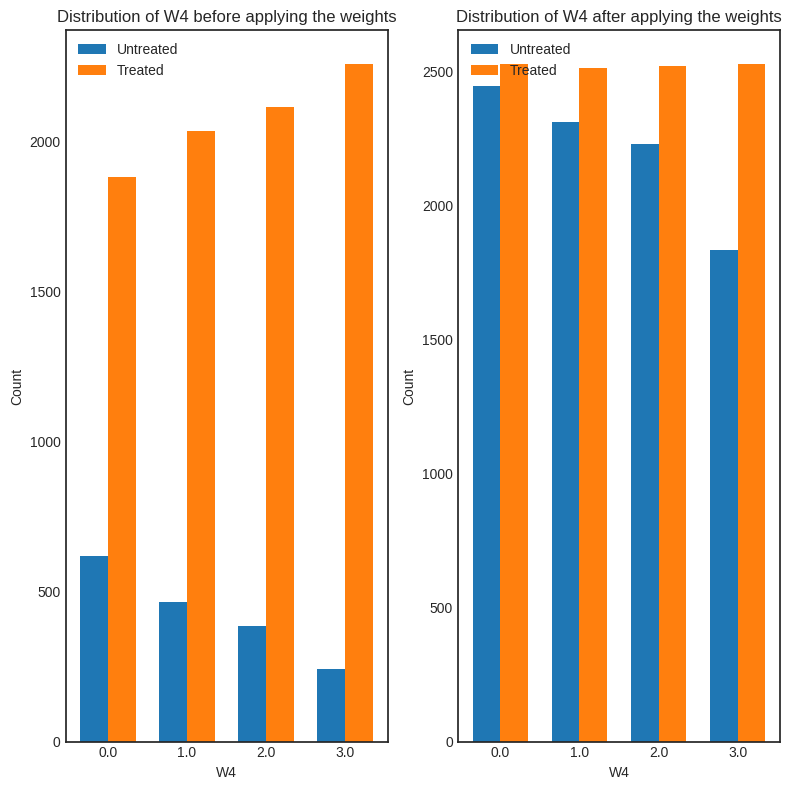

In [15]:
interpretation = causal_estimate_ipw.interpret(method_name="confounder_distribution_interpreter", fig_size=(8,8), font_size=12, var_name='W4', var_type='discrete')